In [12]:
from datetime import datetime
import meme.archive
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
local_time_zone = pytz.timezone('US/Pacific')
import warnings
warnings.filterwarnings("ignore")

In [2]:
main_quads = ['QUAD:LI26:201:BCTRL', 'QUAD:LI26:301:BCTRL', 'QUAD:LI26:401:BCTRL',
        'QUAD:LI26:501:BCTRL', 'QUAD:LI26:601:BCTRL', 'QUAD:LI26:701:BCTRL',
        'QUAD:LI26:801:BCTRL', 'QUAD:LI26:901:BCTRL', 'QUAD:LTUH:620:BCTRL',
        'QUAD:LTUH:640:BCTRL', 'QUAD:LTUH:660:BCTRL', 'QUAD:LTUH:680:BCTRL',
        'QUAD:LTUH:440:BCTRL', 'QUAD:LTUH:460:BCTRL', 'QUAD:LTUS:620:BCTRL',
        'QUAD:LTUS:640:BCTRL', 'QUAD:LTUS:660:BCTRL', 'QUAD:LTUS:680:BCTRL',
        'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 'QUAD:IN20:425:BCTRL',
        'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']

other_quads = ['QUAD:LI21:201:BCTRL', 'QUAD:LI21:211:BCTRL', 'QUAD:LI21:271:BCTRL',
            'QUAD:LI21:278:BCTRL', 'QUAD:LI21:221:BCTRL', 'QUAD:LI21:251:BCTRL',
            'QUAD:LI24:740:BCTRL', 'QUAD:LI24:860:BCTRL', 'SOLN:IN20:121:BCTRL',
            'QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL']


In [48]:
start_time = datetime(2023, 11, 1, 0, 00, 00)
end_time = datetime(2023, 12, 1, 0, 00, 00)
test_pv = ['BEND:DMPH:400:BACT', 'SIOC:SYS0:ML00:AO627']

In [49]:
data_test = meme.archive.get_dataframe(test_pv, start_time, end_time, timeout=500)
data_test.shape

2024-02-26T19:01:19.423108626 WARN pvxs.client.io Server 134.79.151.36:41337 no supported auth.  try to force 'anonymous'


(3335666, 2)

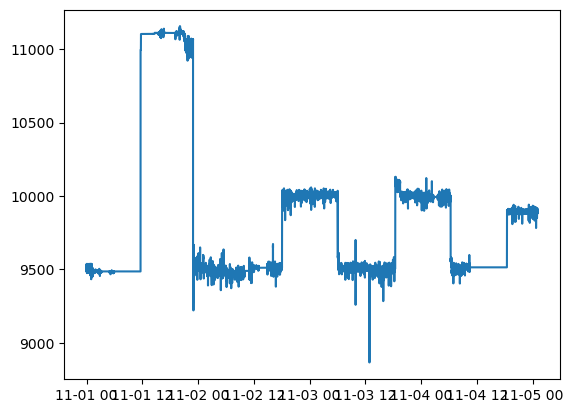

In [60]:
plt.plot(data_test.index[:500000], data_test['SIOC:SYS0:ML00:AO627'][:500000])

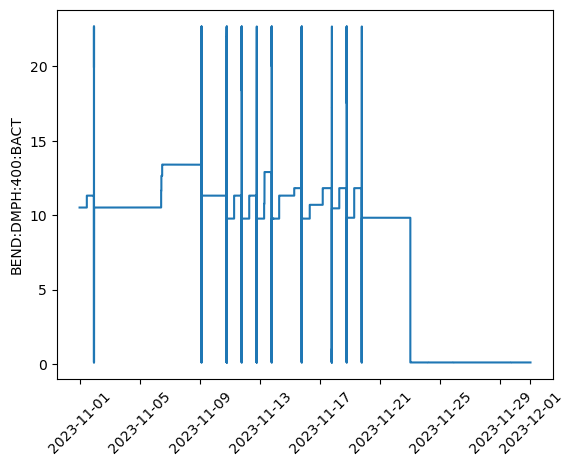

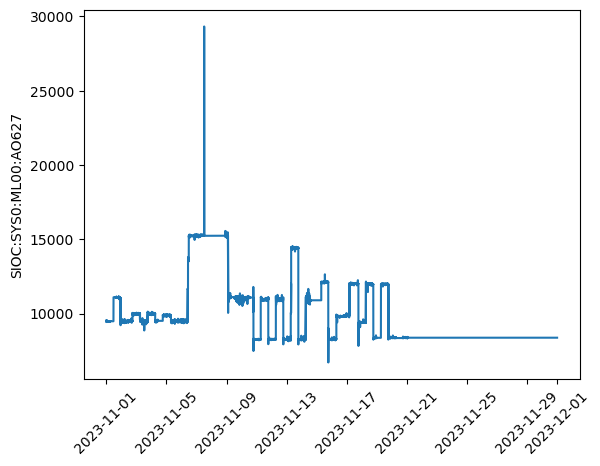

In [58]:
for i, key in enumerate(data_test.keys()):
    plt.figure()
    plt.plot(data_test.index, data_test[key])
    plt.ylabel(key)
    plt.tick_params(axis='x', rotation=45)

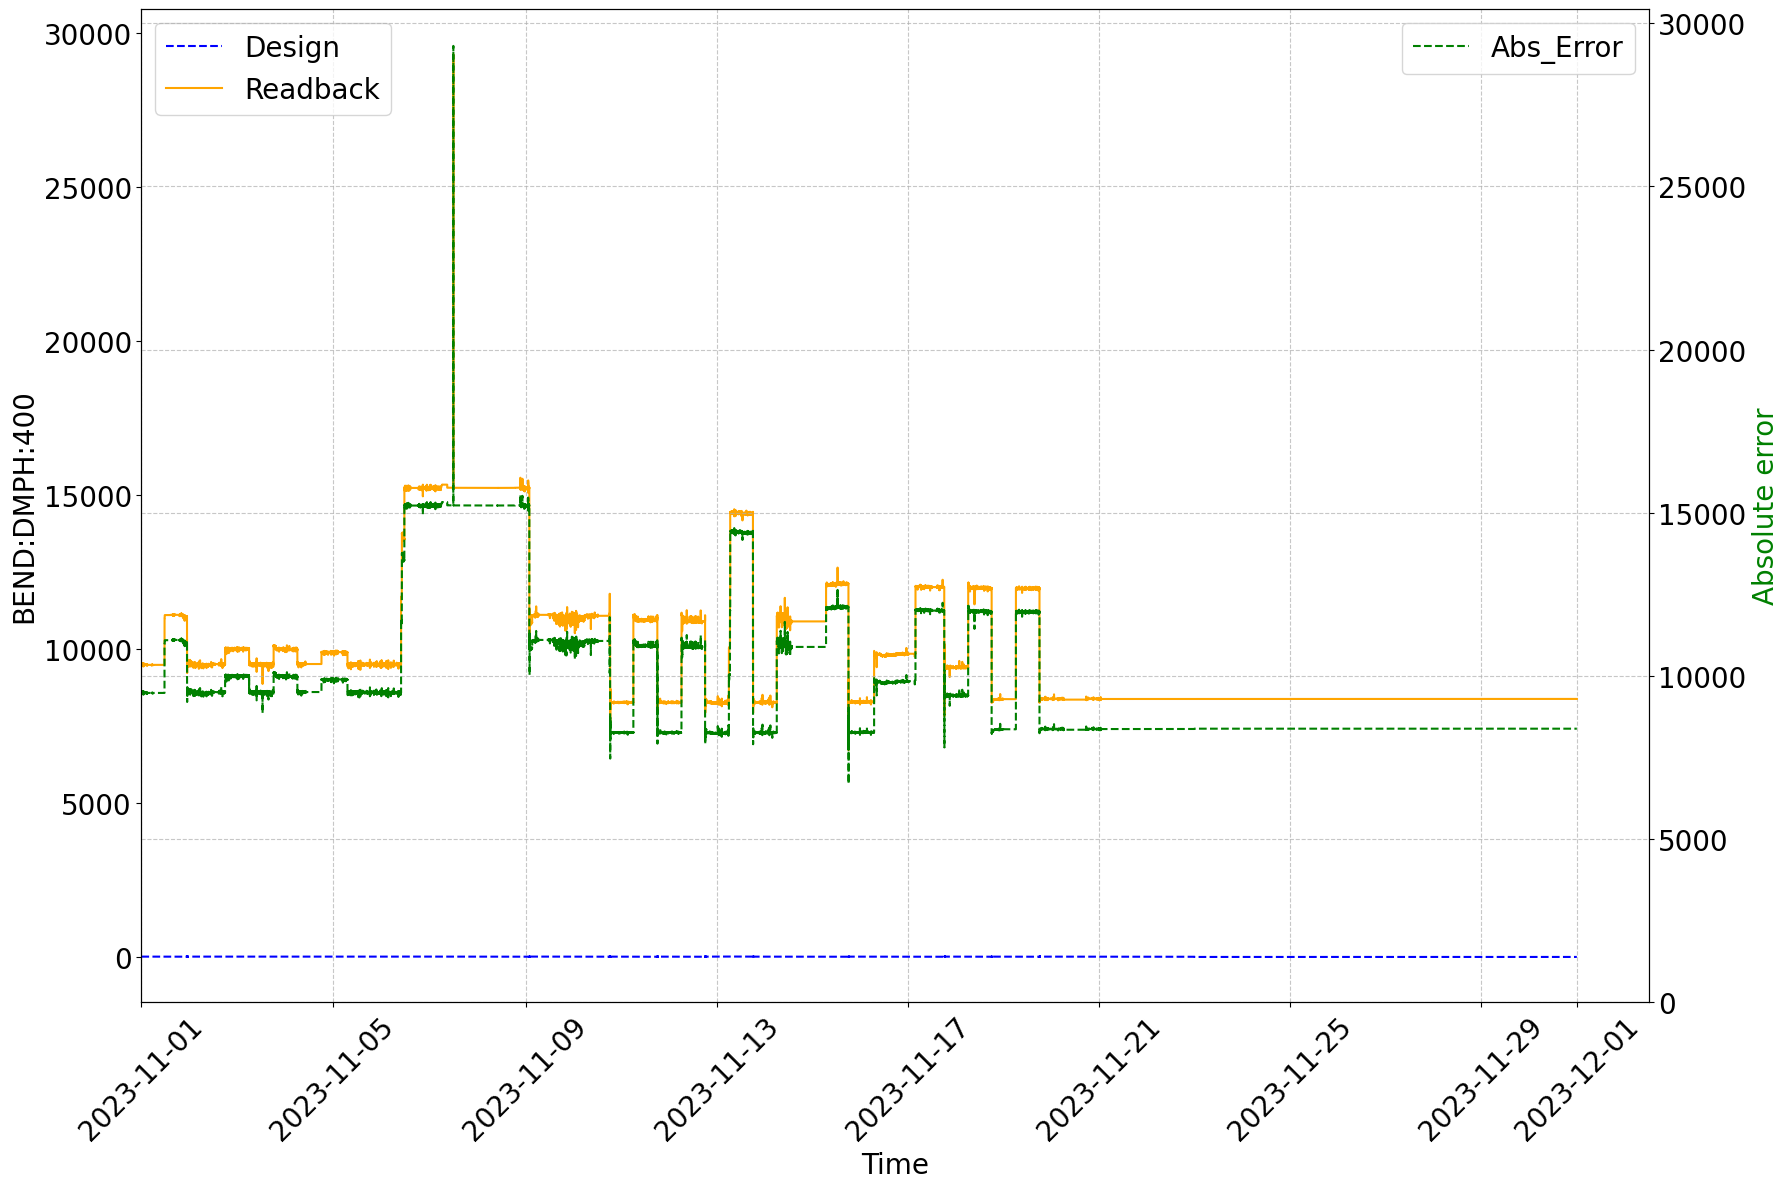

In [51]:
fontsize = 20
fig, ax = plt.subplots(figsize=(18,  12))
# data = meme.archive.get_dataframe([pv,quads_ltuh_bact[index]], start_time, end_time, timeout=100)
data_test = data_test.iloc[1:]

ax2 = ax.twinx()
ax.plot(data_test.index , data_test[test_pv[0]], color='blue', linestyle='--', label='Design')
ax.plot(data_test.index , data_test[test_pv[1]], color='orange', label='Readback')
abs_error = (data_test[test_pv[0]] - data_test[test_pv[1]]).abs()
ax2.plot(data_test.index, abs_error, color='green', label='Abs_Error', linestyle='--')
# ax2.plot(data_test.index, abs_error, color='green', label='Abs_Error=%.5f'% abs_error.mean(), linestyle='--')
ax.set_xlim(left=data_test.index[0])
ax.set_xlabel('Time', fontsize=fontsize)
ax.set_ylabel(':'.join(test_pv[0].split(':')[:3]), fontsize=fontsize)
ax2.set_ylabel('Absolute error', fontsize=fontsize, color='green')
ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='upper left')
ax2.legend(fontsize=fontsize, loc='upper right')
ax2.set_ylim(bottom=-0)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

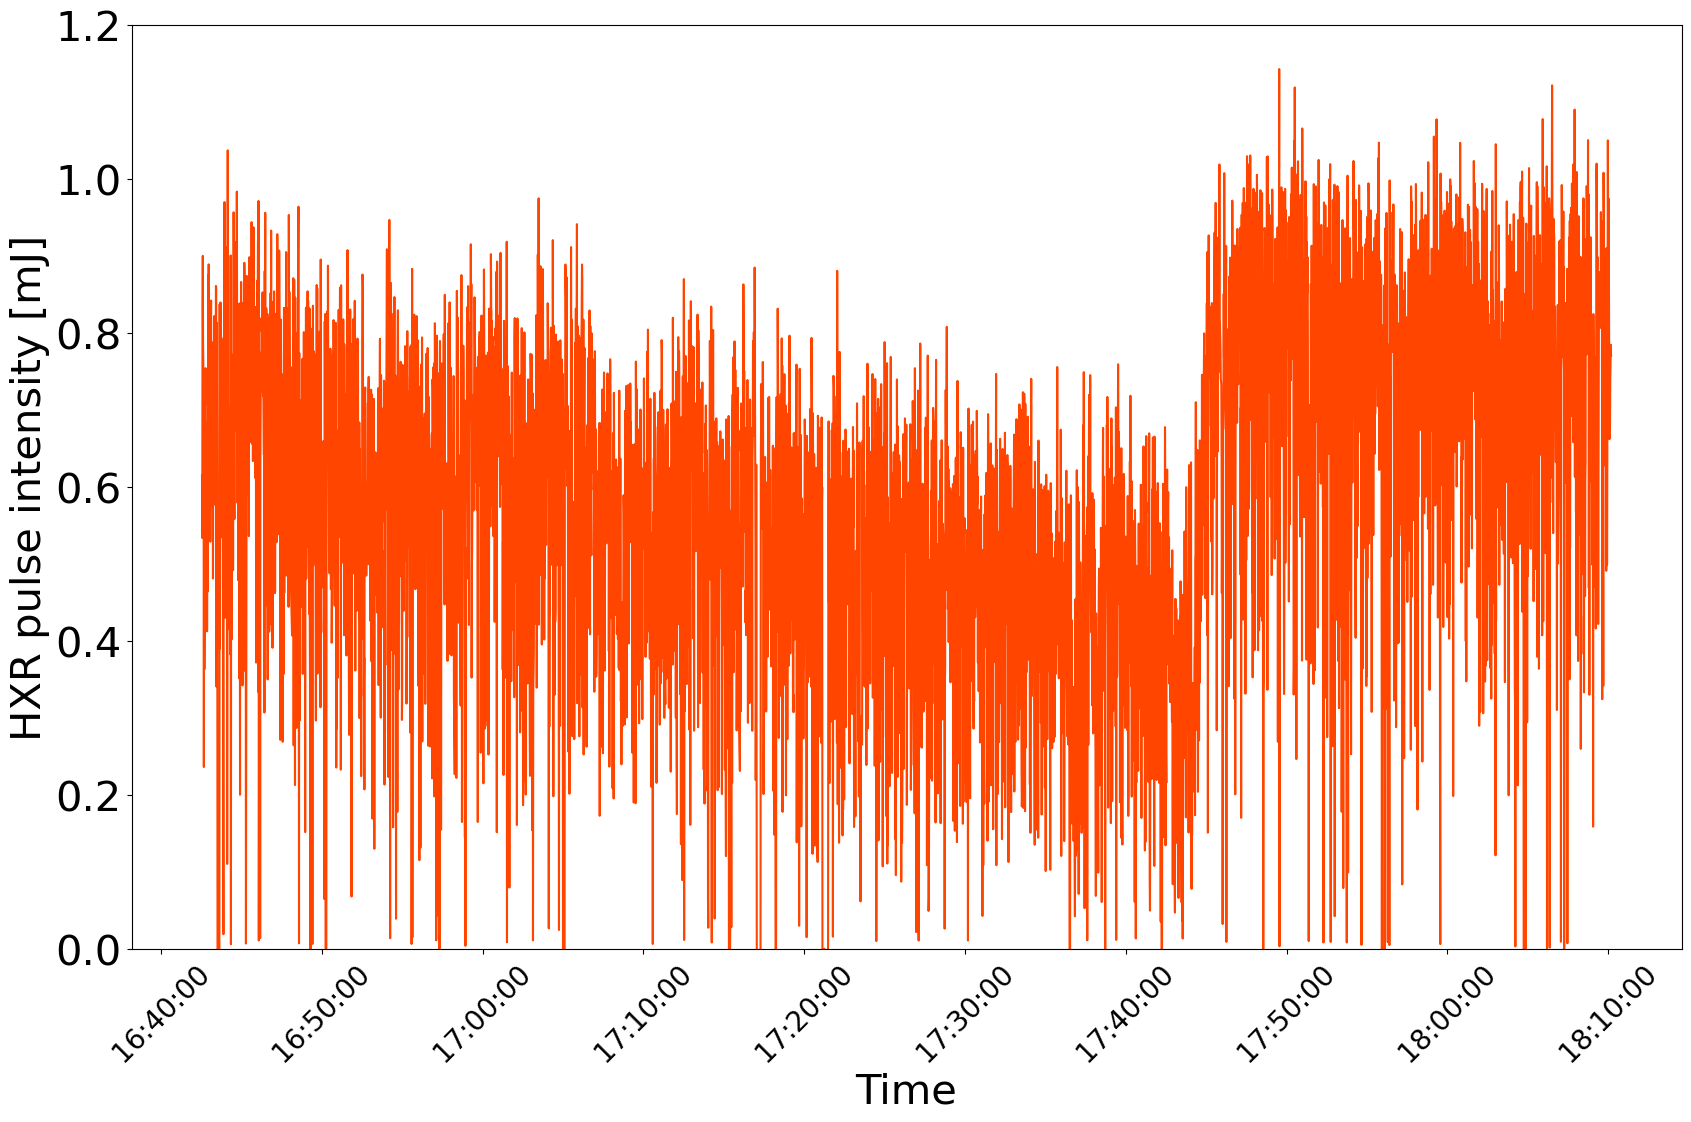

In [48]:
import matplotlib.dates as mdates
fontsize = 30
# for pv in test_pv:
#     plt.figure()
#     plt.plot(data[pv])
#     plt.ylabel(pv)
data_to_plot = data[30000:35000]

plt.figure(figsize=(20,12))
plt.plot(data_to_plot.index , data_to_plot, color='orangered')
plt.xlabel('Time', fontsize=fontsize)
plt.ylabel('HXR pulse intensity [mJ]', fontsize=fontsize)
plt.tick_params(axis='x', rotation=45, labelsize=20)
plt.tick_params(axis='y', labelsize=fontsize)
plt.ylim([0,1.2])
# plt.xlim([pd.Timestamp('2024-02-22 23:25:00.524267776-0800', tz='US/Pacific'), pd.Timestamp('2024-02-22 23:55:00.524267776-0800', tz='US/Pacific')])
# time_fmt = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(time_fmt)
# plt.tick_params(axis='x', rotation=45, labelsize=fontsize)

## Pull data from archive for FEL tuning study

In [13]:
eV_to_joules = 1.60218e-19 

In [14]:
def convert_to_dataframe_no_filling_gap(archive_data, pv_name=None):

    data_frames = {}
    for pv_data in archive_data:
        df = pd.DataFrame({
            'datetime': pd.to_datetime(pv_data['value']['value']['secondsPastEpoch'] * 1e9 + pv_data['value']['value']['nanoseconds'], utc=True),
            pv_data['pvName']: pv_data['value']['value']['values']
        }).set_index('datetime')
        data_frames[pv_data['pvName']] = df

    # Determine the base DataFrame
    if pv_name and pv_name in data_frames:
        base_df = data_frames[pv_name].reset_index()
    else:
        # Find the DataFrame with the most timestamps
        base_df = max(data_frames.values(), key=lambda df: df.index.size).reset_index()

    # Merge other dataframes to the base_df using merge_asof
    for name, df in data_frames.items():
        if name != pv_name:
            base_df = pd.merge_asof(base_df, df.reset_index(), on='datetime', direction='backward').set_index('datetime')

    # Drop the duplicated column if exists and rename appropriately
    for name in data_frames:
        if f'{name}_x' in base_df.columns:
            base_df.drop(columns=[f'{name}_x'], inplace=True)
        if f'{name}_y' in base_df.columns:
            base_df.rename(columns={f'{name}_y': name}, inplace=True)

    # Remove rows with NaN values
    base_df.dropna(inplace=True)

    # Reorder columns to match the order of PVs in archive_data
    column_order = [pv_data['pvName'] for pv_data in archive_data if pv_data['pvName'] in base_df.columns]
    base_df = base_df[column_order]

    # Convert timezone from UTC to 'US/Pacific'
    base_df = base_df.tz_convert('US/Pacific')
    
    return base_df



In [15]:
def group_sample(sample_set, pv_signal):

    # Step 1: Create a Boolean mask indicating where rows change
    changes = sample_set[pv_signal].ne(sample_set[pv_signal].shift()).any(axis=1)
    
    # Step 2: Calculate the cumulative sum of changes to create group identifiers
    sample_set['group'] = changes.cumsum()
    
    # Step 3: Count the number of occurrences in each group
    group_counts = sample_set.groupby('group').size()
    
    # Optional Step 4: Extract indices for each group
    group_indices = sample_set.groupby('group').apply(lambda x: x.index.tolist())
    
    columns_to_average = [col for col in sample_set.columns if col != 'group']
    # Convert datetime to Unix timestamp for averaging (keeping timezone)
    sample_set['datetime_numeric'] = sample_set.index.tz_localize(None).astype('int64') 
    
    # Group by 'group' and calculate the mean for datetime and other columns
    grouped_datetime = sample_set.groupby('group')['datetime_numeric'].mean()
    grouped_other_cols = sample_set.groupby('group')[columns_to_average].mean()
    
    # Convert the averaged Unix timestamp back to datetime (reapply timezone)
    grouped_datetime = pd.to_datetime(grouped_datetime).dt.tz_localize('UTC').dt.tz_convert(local_time_zone)
    
    # Manually adjust the datetime by adding 7 hours
    grouped_datetime += pd.Timedelta(hours=7)
    
    # Combine the averaged datetime with other columns
    grouped_df = pd.concat([grouped_datetime, grouped_other_cols], axis=1)
    
    # Resetting index to make 'group' a column instead of an index
    grouped_df.reset_index(inplace=True)
    
    # Optional: reorder columns to put datetime first
    grouped_df = grouped_df[['group', 'datetime_numeric'] + [col for col in grouped_df.columns if col not in ['group', 'datetime_numeric']]]
    
    # Rename the datetime column
    grouped_df.rename(columns={'datetime_numeric': 'average_datetime'}, inplace=True)
    
    # Display the new DataFrame
    return grouped_df

In [16]:
quads_inj_bctrl = ['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 
             'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']
quads_linac_bctrl = ['QUAD:LI21:201:BCTRL', 'QUAD:LI21:211:BCTRL', 'QUAD:LI21:221:BCTRL', 'QUAD:LI21:251:BCTRL', 
               'QUAD:LI21:271:BCTRL', 'QUAD:LI21:278:BCTRL', 'QUAD:LI24:740:BCTRL', 'QUAD:LI24:860:BCTRL', 
               'QUAD:LI26:201:BCTRL', 'QUAD:LI26:301:BCTRL', 'QUAD:LI26:401:BCTRL', 'QUAD:LI26:501:BCTRL', 
               'QUAD:LI26:601:BCTRL', 'QUAD:LI26:701:BCTRL', 'QUAD:LI26:801:BCTRL', 'QUAD:LI26:901:BCTRL']
quads_ltuh_bctrl = ['QUAD:LTUH:440:BCTRL', 'QUAD:LTUH:460:BCTRL', 'QUAD:LTUH:620:BCTRL', 'QUAD:LTUH:640:BCTRL', 
              'QUAD:LTUH:660:BCTRL', 'QUAD:LTUH:680:BCTRL']
quads_ltus_bctrl = ['QUAD:LTUS:BCTRL', 'QUAD:LTUS:640:BCTRL', 'QUAD:LTUS:660:BCTRL', 'QUAD:LTUS:680:BCTRL']
quads_all_bctrl = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + quads_ltus_bctrl
# get the BACT PV lists for quads
quads_inj_bact = [quad.replace("BCTRL", "BACT") for quad in quads_inj_bctrl] 
quads_linac_bact = [quad.replace("BCTRL", "BACT") for quad in quads_linac_bctrl] 
quads_ltuh_bact = [quad.replace("BCTRL", "BACT") for quad in quads_ltuh_bctrl] 
quads_ltus_bact = [quad.replace("BCTRL", "BACT") for quad in quads_ltus_bctrl] 

blen = ['BLEN:LI21:265:AIMAX1H', 'BLEN:LI24:886:BIMAX1H']
bcharge = ['SIOC:SYS0:ML00:CALC038', 'SIOC:SYS0:ML00:CALC252'] # at gun, after BC1 # ['BPMS:IN20:221:TMIT1H', 'BPMS:LI21:233:TMIT1H', 'BPMS:LI24:801:TMIT1H'] # at gun, BC1, BC2 
hxr_energy = ['BEND:DMPH:400:BACT','SIOC:SYS0:ML00:AO627'] # beam energy, photon energy
sxr_energy = ['BEND:DMPS:400:BDES','SIOC:SYS0:ML00:AO628']
hxr_intensity = ['GDET:FEE1:241:ENRC1H'] #, 'SIOC:SYS0:ML00:AO627'] # number of photon, photon energy
laser_iris_status = ['IRIS:LR20:130:CONFG_SEL'] # the number of states represents the iris size: 1 [1.8mm], 2 [1.6mm], 3 [1.4mm], 4 [1.2mm], 5 [1.1mm], 6 [1.0mm], 7 [0.8mm]

status_name = ['Bunch length at BC1', 'Bunch length at BC2', 'Charge at gun [pC]', 'Charge after BC1 [pC]', 
               'HXR electron energy [GeV]', 'HXR photon energy [eV]', 'laser_iris_status']
status_from_archive = blen + bcharge + hxr_energy + laser_iris_status
bpm_signal = ['BPMS:DMPH:381:TMIT1H']
final_columns = quads_all_bctrl + ['hxr_pulse_intensity'] + status_name


In [9]:
# Comparison between the BCTRL and BACT values

start_time = datetime(2024, 1, 1, 00, 00, 00)
end_time = datetime(2024, 2, 1, 00, 00, 00)
print('Data size comparison:')
for pv in quads_all_bctrl:
    test_data_bctrl = meme.archive.get(pv, start_time, end_time, timeout=100)
    test_data_bact = meme.archive.get(pv.replace("BCTRL", "BACT"), start_time, end_time, timeout=100) # get BACT data instead of BCTRL data
    print(pv.split(':BCTRL')[0],'\nBCTRL: {}, BACT: {}'.format(test_data_bctrl['values'].shape[0], 
                                                               test_data_bact['values'].shape[0]))

Data size comparison:


2024-02-20T13:00:32.551098985 WARN pvxs.client.io Server 134.79.151.36:41337 no supported auth.  try to force 'anonymous'


QUAD:IN20:121 
BCTRL: 140, BACT: 1722589
QUAD:IN20:122 
BCTRL: 170, BACT: 1759349
QUAD:IN20:361 
BCTRL: 255, BACT: 2668602
QUAD:IN20:371 
BCTRL: 255, BACT: 2667029
QUAD:IN20:425 
BCTRL: 266, BACT: 2669452
QUAD:IN20:441 
BCTRL: 251, BACT: 2647517


KeyboardInterrupt: 

In [26]:
quads_all_updated = [quad.replace("BCTRL", "BACT") for quad in quads_all_bctrl] 

In [1]:
 # Archive all the BCTRL data
start_time = datetime(2023, 7, 1, 00, 00, 00)
end_time = datetime(2023, 8, 1, 00, 00, 00)

all_data = meme.archive.get(quads_all+hxr_intensity+status_from_archive+bpm_signal, start_time, end_time, timeout=200)
result_df = convert_to_dataframe_no_filling_gap(all_data, pv_name='GDET:FEE1:241:ENRC1H')
print('Number of total samples:', result_df.shape[0])

NameError: name 'datetime' is not defined

In [45]:
# Archive all the BACT data
start_time = datetime(2024, 2, 26, 14, 00, 00)
end_time = datetime(2024, 2, 26, 15, 00, 00)
all_data_inj = meme.archive.get([quad.replace("BCTRL", "BACT") for quad in quads_inj_bctrl], start_time, end_time, timeout=1000)
all_data_linac = meme.archive.get([quad.replace("BCTRL", "BACT") for quad in quads_linac_bctrl], start_time, end_time, timeout=1000)
all_data_ltuh = meme.archive.get([quad.replace("BCTRL", "BACT") for quad in quads_ltuh_bctrl], start_time, end_time, timeout=1000)
all_data_ltus = meme.archive.get([quad.replace("BCTRL", "BACT") for quad in quads_ltus_bctrl], start_time, end_time, timeout=1000)
all_data_others = meme.archive.get(hxr_intensity+status_from_archive+bpm_signal, start_time, end_time, timeout=200)

all_data = all_data_inj + all_data_linac + all_data_ltuh + all_data_ltus + all_data_others
# all_data.append(each_data)
result_df = convert_to_dataframe_no_filling_gap(all_data, pv_name='GDET:FEE1:241:ENRC1H')
print('Number of total samples:', result_df.shape[0])

2024-02-26T15:36:22.255101295 WARN pvxs.client.io Server 134.79.151.36:41337 no supported auth.  try to force 'anonymous'


Number of total samples: 3601


### Filtering out the unphysical samples 

In [46]:
# result_df['hxr_pulse_intensity'] = result_df['SIOC:SYS0:ML00:AO627'] * eV_to_joules * result_df['GDET:FEE1:241:ENRC1H'] # photon_energy_ev * eV_to_joules * number_of_photons
condition = (result_df['BPMS:DMPH:381:TMIT1H']*eV_to_joules*1e12 > 170) & (result_df['GDET:FEE1:241:ENRC1H'] < 10)
final_df = result_df[condition]
final_df.rename(columns={'GDET:FEE1:241:ENRC1H': 'hxr_pulse_intensity'}, inplace=True)
status_mapping = dict(zip(status_from_archive, status_name))
final_df.rename(columns=status_mapping, inplace=True)
final_df = final_df.drop('BPMS:DMPH:381:TMIT1H', axis=1)
print('Number of total samples:', final_df.shape[0])

Number of total samples: 3570


In [108]:
# grouping the samples that share the same settings of tuning knobs
grouped_df = group_sample(final_df, pv_signal=quads_inj_bact+quads_linac_bact+quads_ltuh_bact)
print('Number of final samples after grouping:', grouped_df.shape[0])

Number of final samples after grouping: 1187602


### Save dataframe to pickle file

In [47]:
final_df.to_pickle('/sdf/home/z/zihanzhu/lcls/fel_tuning/dataset/hxr_archiver_Febtest_updated.pkl')
# grouped_df.to_pickle('/sdf/home/z/zihanzhu/lcls/fel_tuning/hxr_archiver_Sep_small.pkl')

### FEL pulse intensity PV 'GDET:FEE1:241:ENRC1H' analysis

In [7]:
start_time = datetime(2023, 11, 6, 00, 00, 00)
end_time = datetime(2023, 11, 7, 00, 00, 00)

data_test = meme.archive.get(quads_all+hxr_intensity+status_from_archive+bpm_signal, start_time, end_time, timeout=100)
data_test_final = convert_to_dataframe_no_filling_gap(data_test, pv_name='GDET:FEE1:241:ENRC1H')
bpm_data_test = meme.archive.get_dataframe(bpm_signal, start_time, end_time, timeout=100)

condition = (data_test_final['BPMS:DMPH:381:TMIT1H']*1.60218e-19*1e12 > 170) & (data_test_final['GDET:FEE1:241:ENRC1H'] < 3)

data_test_final_filtered = data_test_final[condition]
print('Number of total samples:', data_test_final.shape[0])
print('Number of samples aftering filtering:', data_test_final_filtered.shape[0])
data_test_final_grouped = group_sample(data_test_final_filtered, pv_signal=quads_inj+quads_linac+quads_ltuh)
print('Number of samples after grouping:', data_test_final_grouped.shape[0])

2024-02-07T09:40:31.630158452 WARN pvxs.client.io Server 134.79.151.36:39010 no supported auth.  try to force 'anonymous'


Number of total samples: 82733
Number of samples aftering filtering: 66107
Number of samples after grouping: 1493


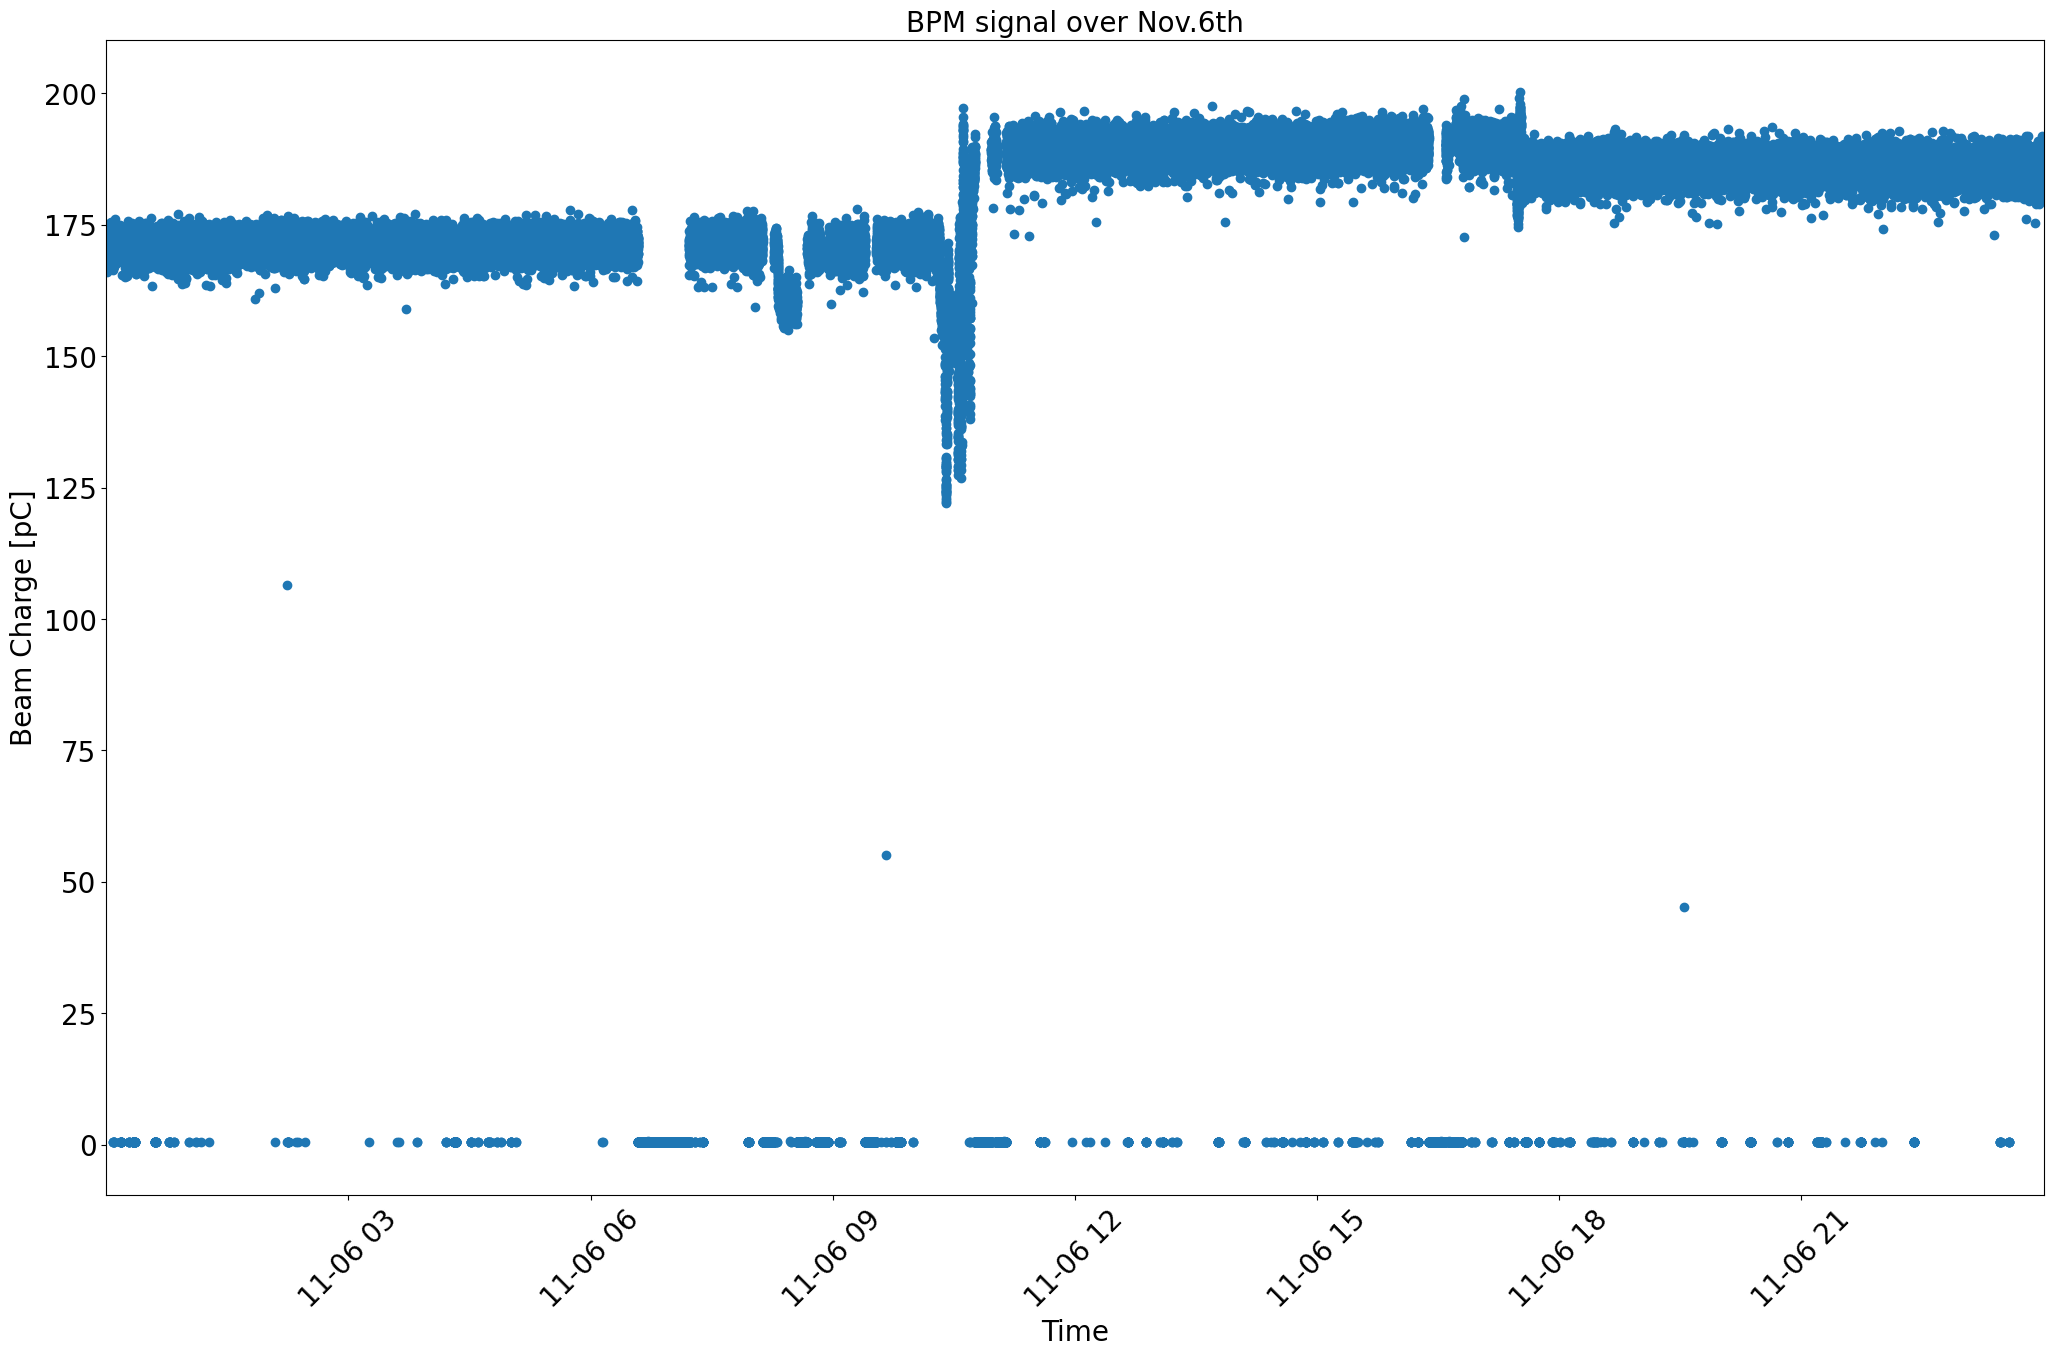

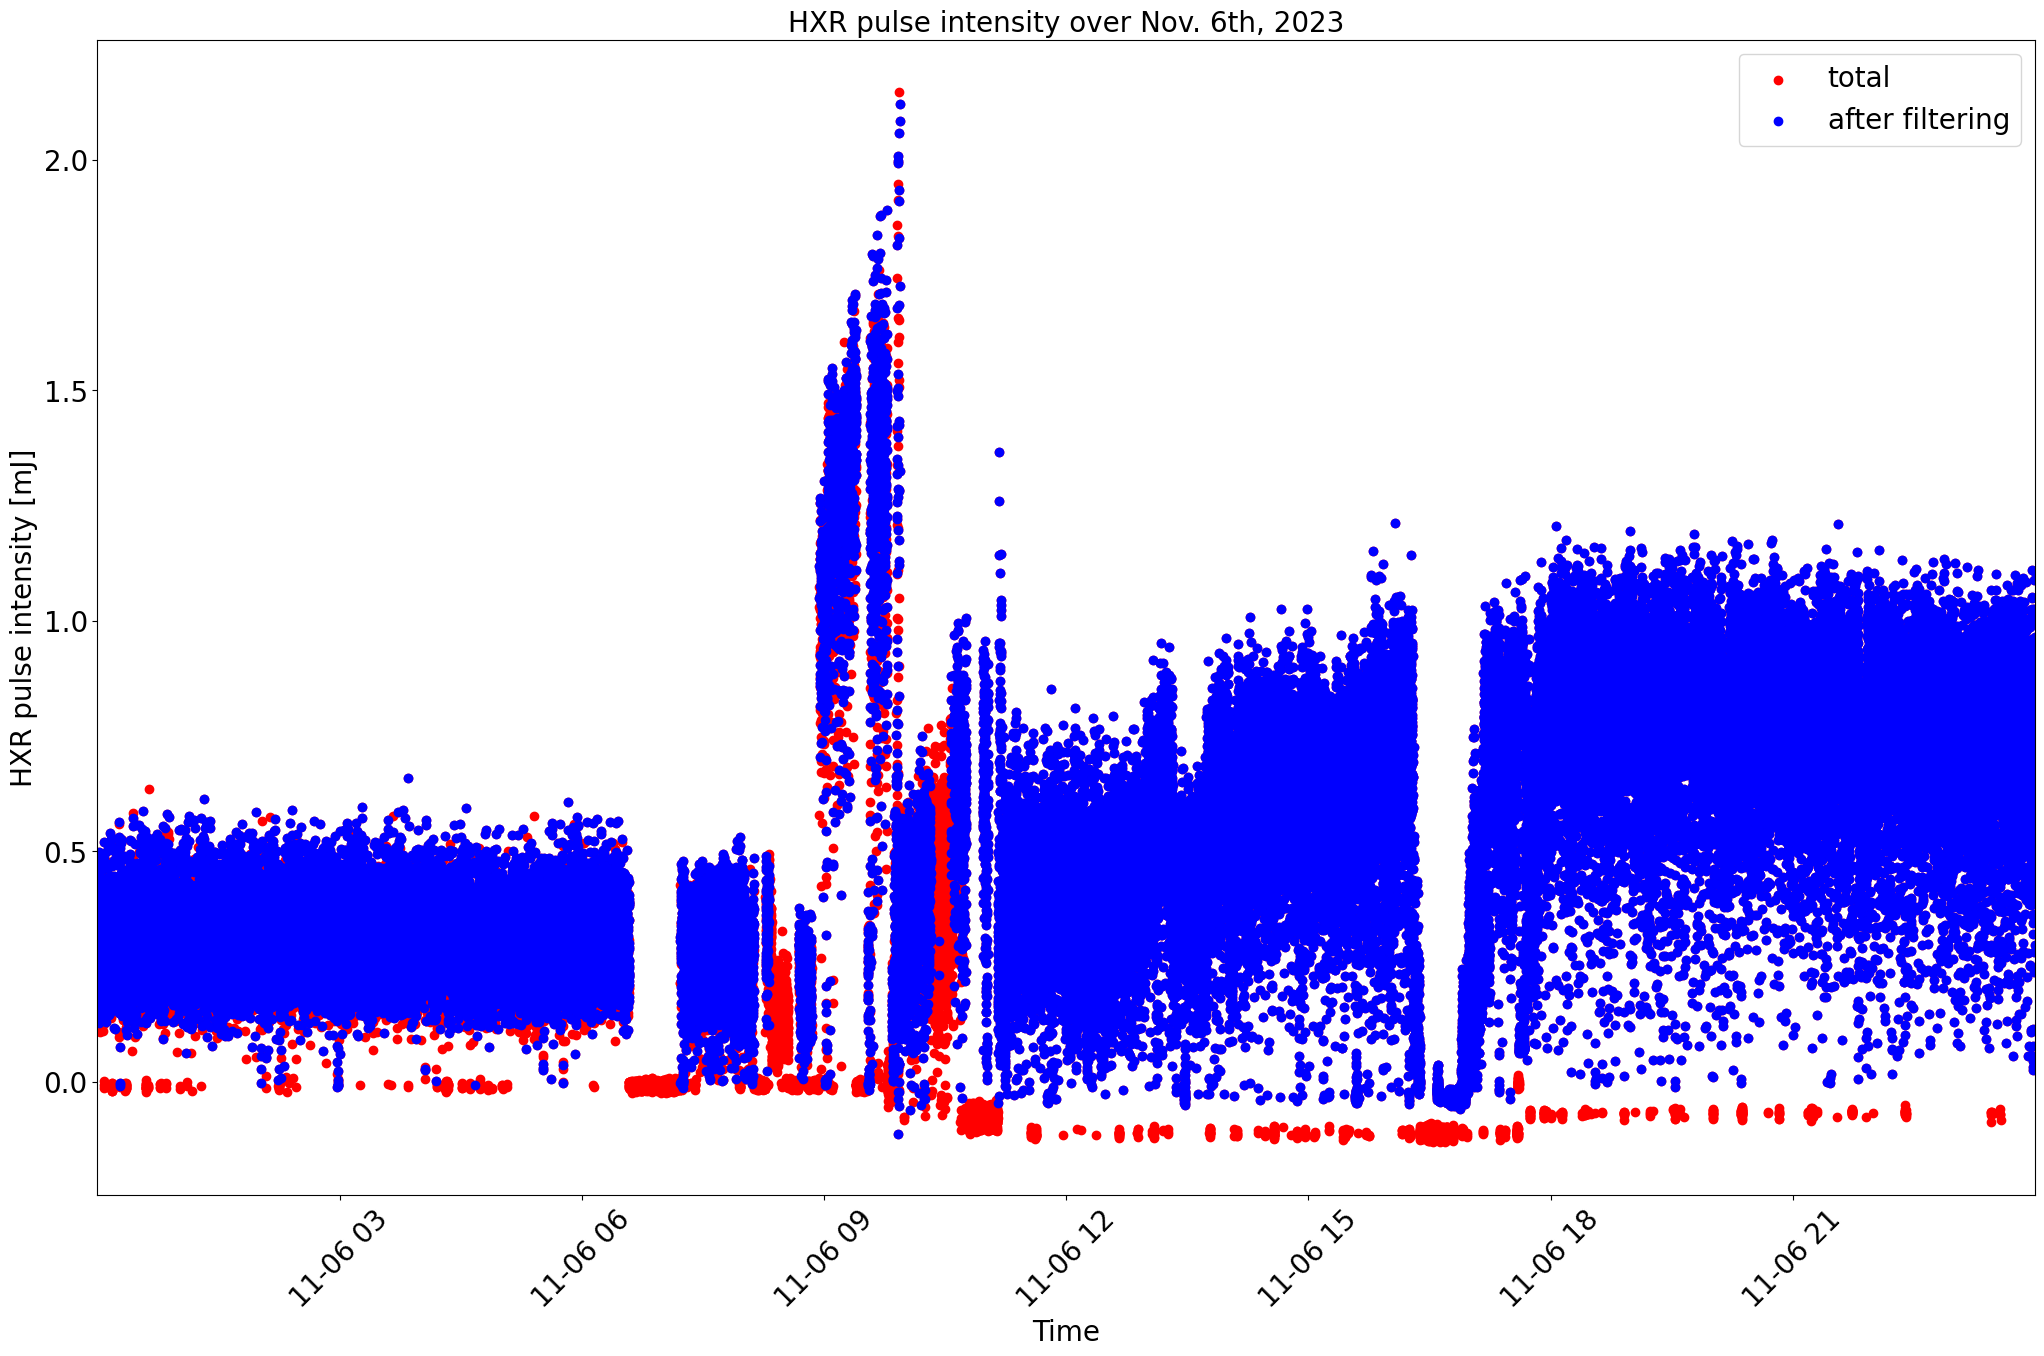

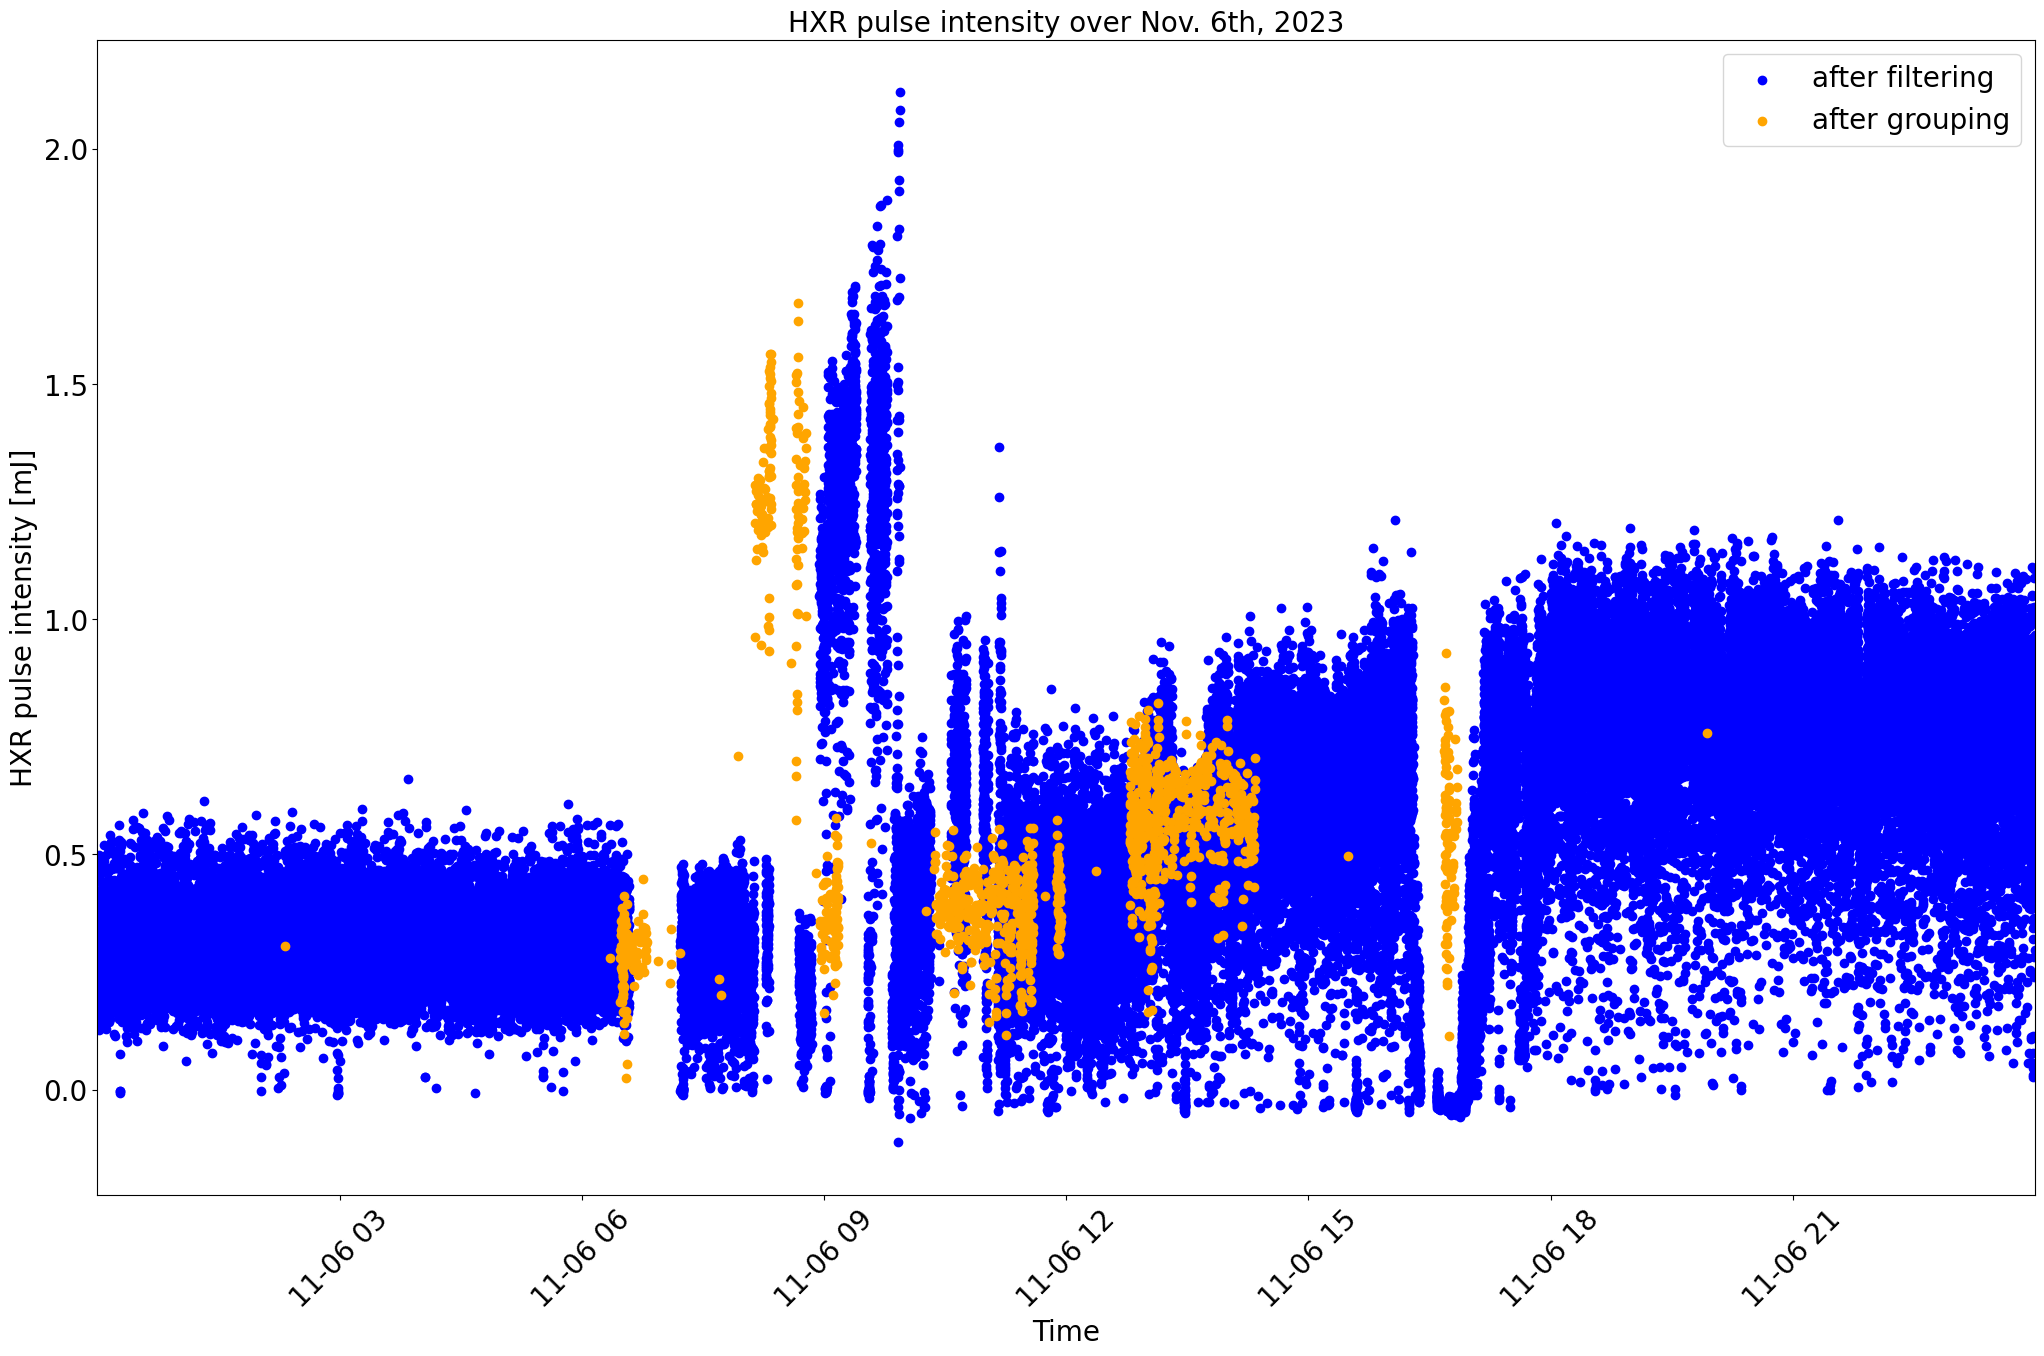

In [118]:
fontsize = 20



plt.figure(figsize=(25,15))
plt.scatter(bpm_data_test.index , bpm_data_test['value']*1.60218e-19*1e12 )
plt.xlabel('Time', fontsize=fontsize)
plt.xlim([data_test_final.index[0],data_test_final.index[-1]])
plt.ylabel('Beam Charge [pC]', fontsize=fontsize)
plt.title('BPM signal over Nov.6th', fontsize=fontsize)
plt.xticks(rotation=45, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

plt.figure(figsize=(25,15))
plt.scatter(data_test_final.index , data_test_final['GDET:FEE1:241:ENRC1H'],color='red',label='total')
plt.scatter(data_test_final_filtered.index , data_test_final_filtered['GDET:FEE1:241:ENRC1H'],color='blue',label='after filtering')
plt.xlabel('Time', fontsize=fontsize)
plt.xlim([data_test_final.index[0],data_test_final.index[-1]])
plt.ylabel('HXR pulse intensity [mJ]', fontsize=fontsize)
plt.title('HXR pulse intensity over Nov. 6th, 2023', fontsize=fontsize)
plt.xticks(rotation=45, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

plt.figure(figsize=(25,15))
plt.scatter(data_test_final_filtered.index , data_test_final_filtered['GDET:FEE1:241:ENRC1H'],color='blue',label='after filtering')
plt.scatter(data_test_final_grouped['average_datetime'], data_test_final_grouped['GDET:FEE1:241:ENRC1H'],color='orange',label='after grouping')
plt.xlabel('Time', fontsize=fontsize)
plt.xlim([data_test_final.index[0],data_test_final.index[-1]])
plt.ylabel('HXR pulse intensity [mJ]', fontsize=fontsize)
plt.title('HXR pulse intensity over Nov. 6th, 2023', fontsize=fontsize)
plt.xticks(rotation=45, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


### QUADs analysis (BCTRL vs BACT)

In [10]:
quads_inj_bctrl = ['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 
                   'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']
quads_linac_bctrl = ['QUAD:LI21:201:BCTRL', 'QUAD:LI21:211:BCTRL', 'QUAD:LI21:221:BCTRL', 'QUAD:LI21:251:BCTRL', 
                     'QUAD:LI21:271:BCTRL', 'QUAD:LI21:278:BCTRL', 'QUAD:LI24:740:BCTRL', 'QUAD:LI24:860:BCTRL', 
                   'QUAD:LI26:201:BCTRL', 'QUAD:LI26:301:BCTRL', 'QUAD:LI26:401:BCTRL', 'QUAD:LI26:501:BCTRL', 
                     'QUAD:LI26:601:BCTRL', 'QUAD:LI26:701:BCTRL', 'QUAD:LI26:801:BCTRL', 'QUAD:LI26:901:BCTRL']
quads_ltuh_bctrl = ['QUAD:LTUH:440:BCTRL', 'QUAD:LTUH:460:BCTRL', 'QUAD:LTUH:620:BCTRL', 'QUAD:LTUH:640:BCTRL', 
                    'QUAD:LTUH:660:BCTRL', 'QUAD:LTUH:680:BCTRL']
quads_ltus_bctrl = ['QUAD:LTUS:620:BCTRL', 'QUAD:LTUS:640:BCTRL', 'QUAD:LTUS:660:BCTRL', 'QUAD:LTUS:680:BCTRL']
quads_all_bctrl = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + quads_ltus_bctrl


quads_inj_bact = ['QUAD:IN20:121:BACT', 'QUAD:IN20:122:BACT', 'QUAD:IN20:361:BACT', 'QUAD:IN20:371:BACT', 
                  'QUAD:IN20:425:BACT', 'QUAD:IN20:441:BACT', 'QUAD:IN20:511:BACT', 'QUAD:IN20:525:BACT']
quads_linac_bact = ['QUAD:LI21:201:BACT', 'QUAD:LI21:211:BACT', 'QUAD:LI21:221:BACT', 'QUAD:LI21:251:BACT', 
                    'QUAD:LI21:271:BACT', 'QUAD:LI21:278:BACT', 'QUAD:LI24:740:BACT', 'QUAD:LI24:860:BACT', 
                   'QUAD:LI26:201:BACT', 'QUAD:LI26:301:BACT', 'QUAD:LI26:401:BACT', 'QUAD:LI26:501:BACT', 
                    'QUAD:LI26:601:BACT', 'QUAD:LI26:701:BACT', 'QUAD:LI26:801:BACT', 'QUAD:LI26:901:BACT']
quads_ltuh_bact = ['QUAD:LTUH:440:BACT', 'QUAD:LTUH:460:BACT', 'QUAD:LTUH:620:BACT', 'QUAD:LTUH:640:BACT', 
                   'QUAD:LTUH:660:BACT', 'QUAD:LTUH:680:BACT']
quads_ltus_bact = ['QUAD:LTUS:620:BACT', 'QUAD:LTUS:640:BACT', 'QUAD:LTUS:660:BACT', 'QUAD:LTUS:680:BACT']
quads_all_bact = quads_inj_bact + quads_linac_bact + quads_ltuh_bact + quads_ltus_bact

2024-02-06T14:47:06.654267224 WARN pvxs.client.io Server 134.79.151.36:39010 no supported auth.  try to force 'anonymous'


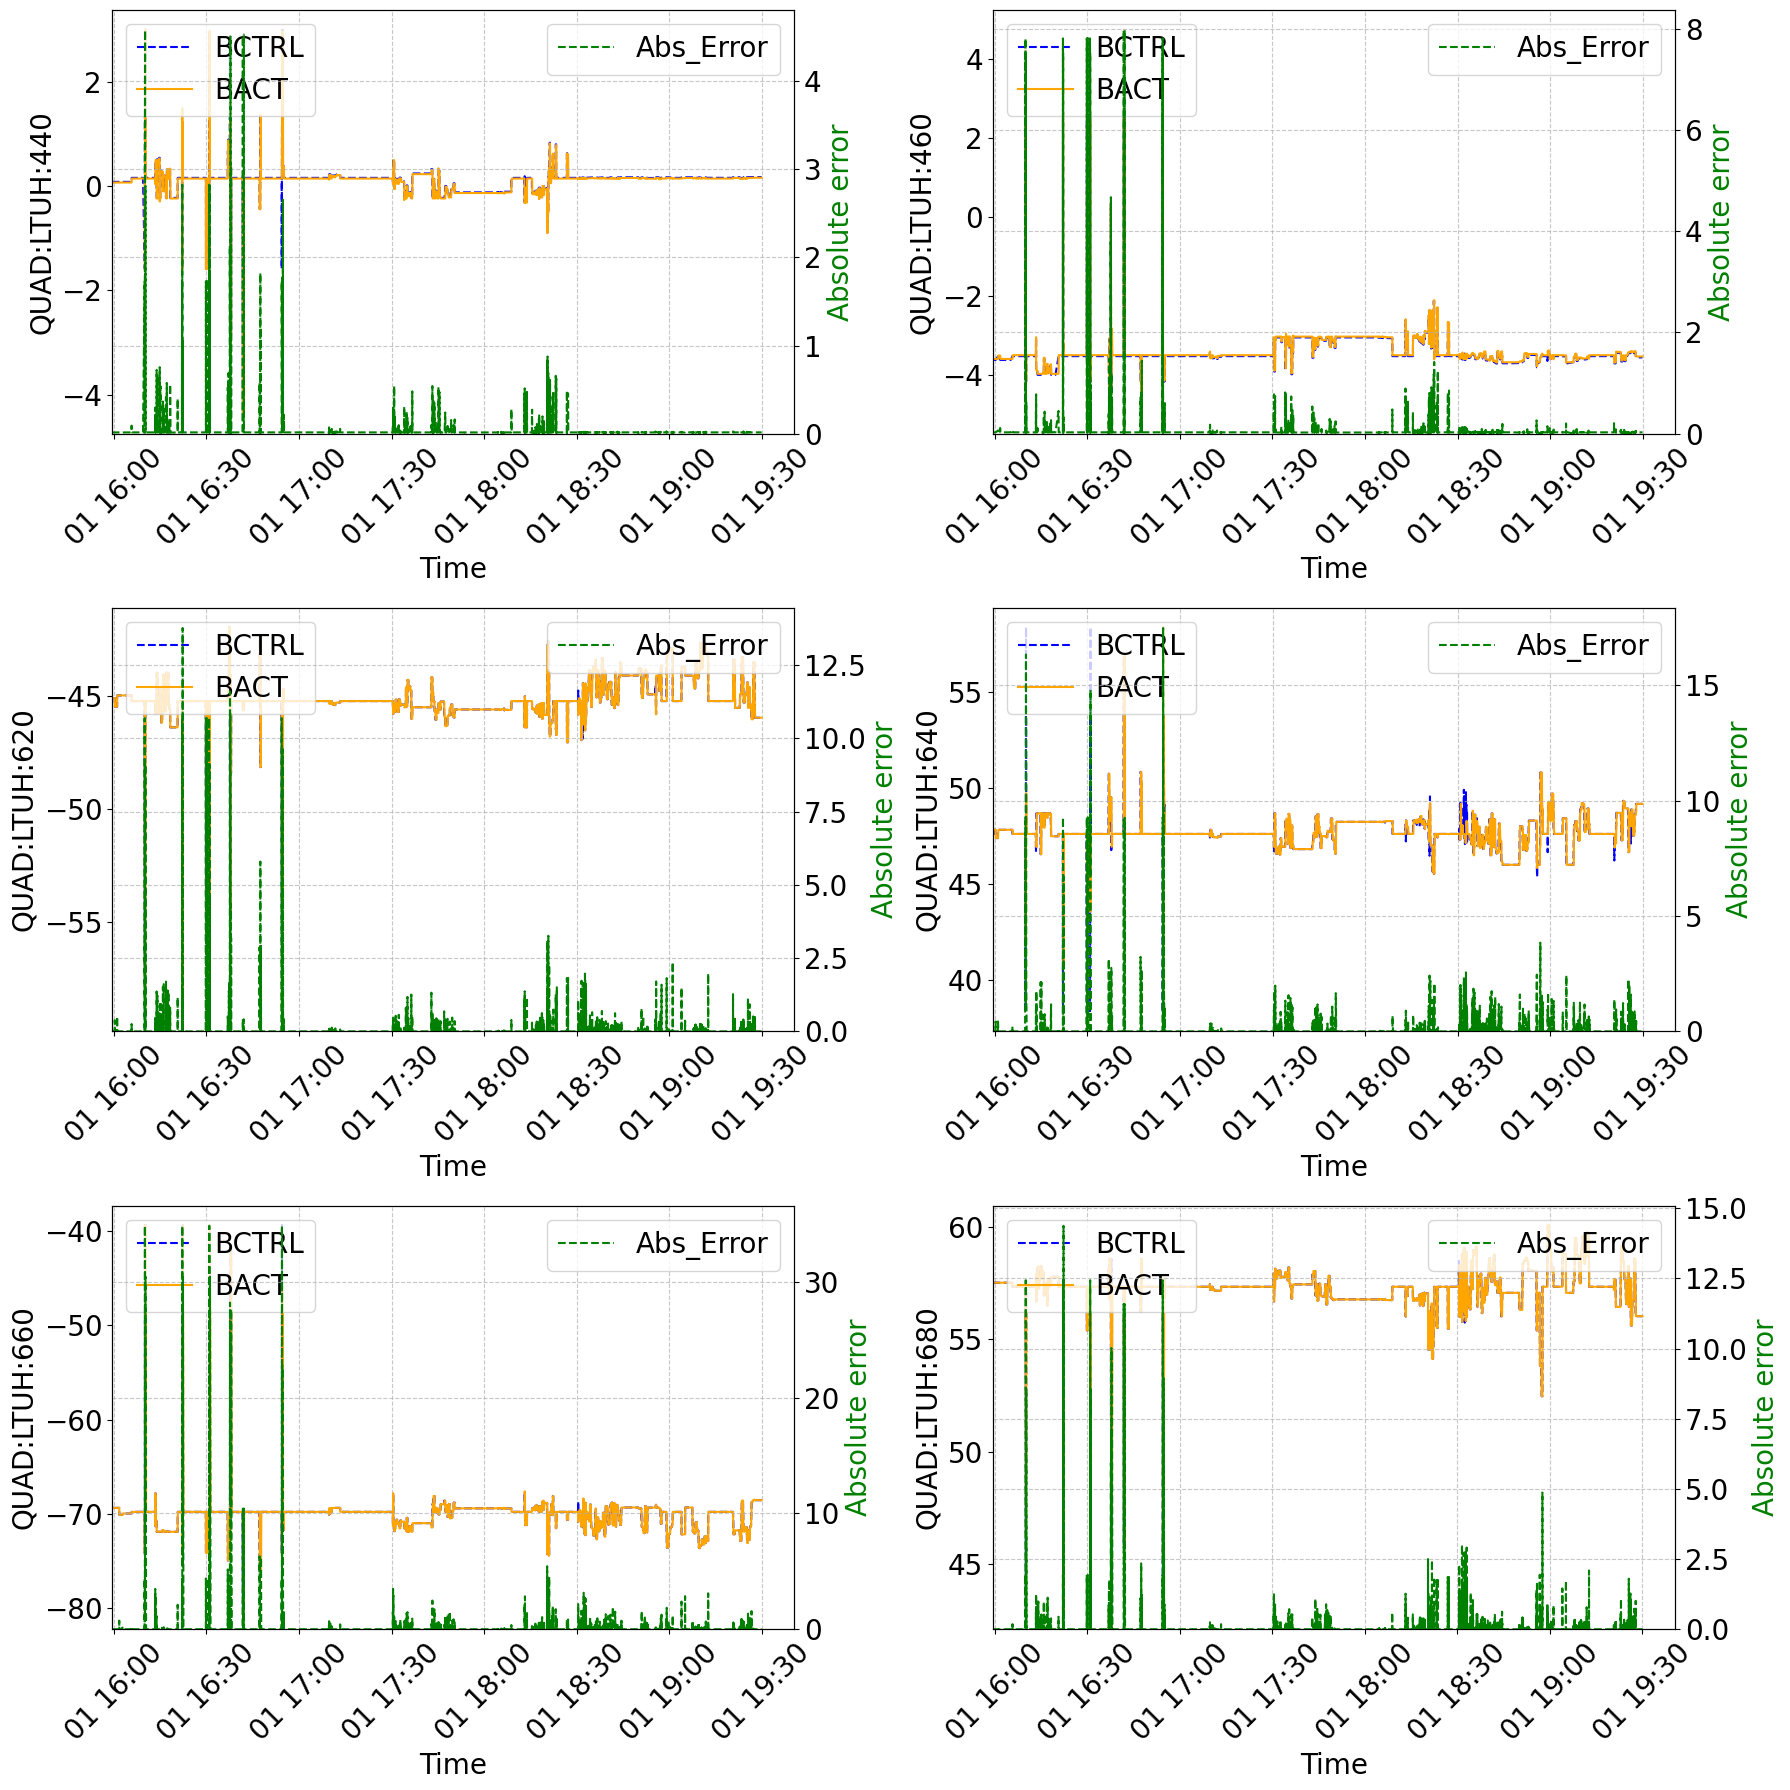

In [108]:
start_time = datetime(2024, 2, 1, 16, 0, 00)
end_time = datetime(2024, 2, 1, 19, 30, 00)

n = len(quads_ltuh_bctrl)
ncols = 2
nrows = int(np.ceil(n / ncols))

fontsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,  6 * nrows))
axes = axes.flatten()  

for index, pv in enumerate(quads_ltuh_bctrl):
    data_quads = meme.archive.get_dataframe([pv,quads_ltuh_bact[index]], start_time, end_time, timeout=100)
    
    ax = axes[index] 
    ax2 = ax.twinx()
    ax.plot(data_quads.index , data_quads[pv], color='blue', linestyle='--', label='BCTRL')
    ax.plot(data_quads.index , data_quads[quads_ltuh_bact[index]], color='orange', label='BACT')
    abs_error = (data_quads[quads_ltuh_bact[index]] - data_quads[pv]).abs()
    ax2.plot(data_quads.index, abs_error, color='green', label='Abs_Error', linestyle='--')
    # ax2.plot(data_quads.index, abs_error, color='green', label='Abs_Error=%.5f'% abs_error.mean(), linestyle='--')
    ax.set_xlim(left=data_quads.index[0])
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel(':'.join(pv.split(':')[:3]), fontsize=fontsize)
    ax2.set_ylabel('Absolute error', fontsize=fontsize, color='green')
    ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax.legend(fontsize=fontsize, loc='upper left')
    ax2.legend(fontsize=fontsize, loc='upper right')
    ax2.set_ylim(bottom=-0)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
    ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [112]:
start_time = datetime(2024, 2, 1, 16, 0, 00)
end_time = datetime(2024, 2, 1, 16, 30, 00)
pv_no_suffix = 'QUAD:LTUH:660'
data_quads = meme.archive.get_dataframe([pv_no_suffix+':BCTRL', pv_no_suffix+':BACT'], start_time, end_time, timeout=100)
abs_error = (data_quads[pv_no_suffix+':BCTRL'] - data_quads[pv_no_suffix+':BACT']).abs()
error_index = []
for i in range(len(abs_error)):
    if abs_error[i] > 10:
        error_index.append(i)
print(error_index)

[614, 615, 616, 617, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 1359, 1360, 1361, 1362, 1363, 1364, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378]


2024-02-06T14:49:28.900823312 WARN pvxs.client.io Server 134.79.151.36:39010 no supported auth.  try to force 'anonymous'


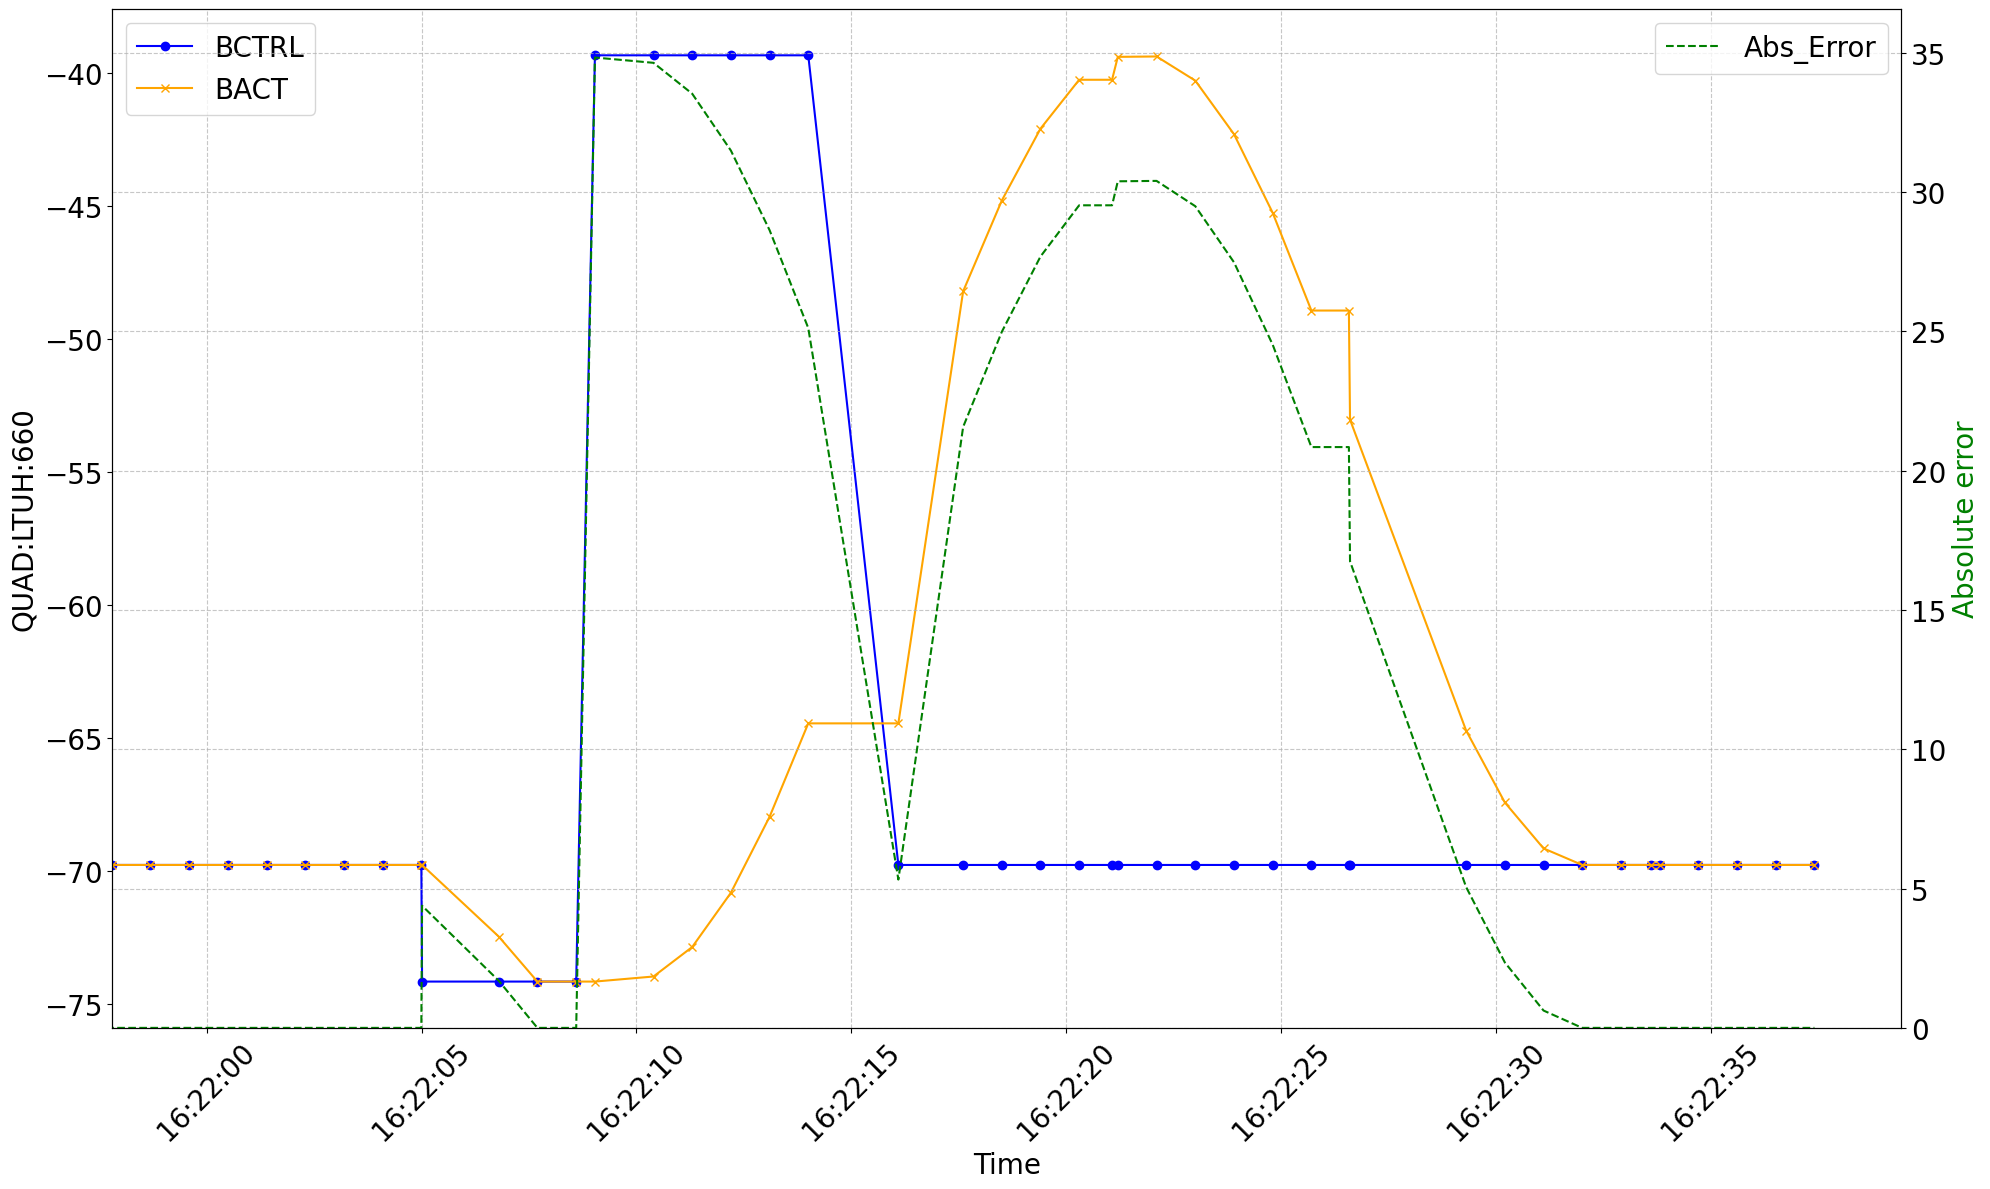

In [116]:
diag_start = 1345
diag_end = 1390
save_fig = 0
data_quads_diag = data_quads.iloc[diag_start:diag_end]

fig, axes = plt.subplots(1, 1, figsize=(20, 12))
ax = axes
ax2 = ax.twinx()
ax.plot(data_quads_diag.index , data_quads_diag[pv_no_suffix+':BCTRL'], color='blue', marker='o', label='BCTRL')
ax.plot(data_quads_diag.index , data_quads_diag[pv_no_suffix+':BACT'], color='orange', marker='x', label='BACT')

ax2.plot(data_quads_diag.index, abs_error[diag_start:diag_end], color='green', label='Abs_Error', linestyle='--')

ax2.set_ylim(bottom=-0)
ax.set_xlabel('Time', fontsize=fontsize)
ax.set_ylabel(pv_no_suffix, fontsize=fontsize)
ax.set_xlim(left=data_quads_diag.index[1])
ax2.set_ylabel('Absolute error', fontsize=fontsize, color='green')
ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='upper left')
ax2.legend(fontsize=fontsize, loc='upper right')
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
# ax.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)
# ax2.set_ylim(top=0.02)
plt.tight_layout()
plt.show()

if save_fig:
    plt.savefig('ctrl_vs_act.png')

### Get machine status before FEL tuning

In [14]:
start_time = datetime(2024, 2, 1, 15, 50, 00)
end_time = datetime(2024, 2, 1, 16, 10, 00)
constant_quads_values_df = meme.archive.get_dataframe(quads_inj_bctrl+quads_linac_bctrl, start_time, end_time, timeout=100)

2024-02-13T10:48:54.918545001 WARN pvxs.client.io Server 134.79.151.36:41337 no supported auth.  try to force 'anonymous'


In [15]:
constant_quads_values_df

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,QUAD:LI21:201:BCTRL,QUAD:LI21:211:BCTRL,...,QUAD:LI24:740:BCTRL,QUAD:LI24:860:BCTRL,QUAD:LI26:201:BCTRL,QUAD:LI26:301:BCTRL,QUAD:LI26:401:BCTRL,QUAD:LI26:501:BCTRL,QUAD:LI26:601:BCTRL,QUAD:LI26:701:BCTRL,QUAD:LI26:801:BCTRL,QUAD:LI26:901:BCTRL
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-31 22:57:22.866694656-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 12:53:46.911396608-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 15:44:43.835767296-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 15:44:43.836590592-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 15:44:43.836831744-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 16:05:43.439134976-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 16:05:43.439300864-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481
2024-02-01 16:05:43.439623424-08:00,0.00469,-0.009,-3.8889,2.960521,-1.25453,-0.001337,2.543719,-2.323882,-7.140307,6.345844,...,0.463045,-0.902205,6.647603,-8.331601,6.291201,-8.204403,16.752272,-19.502833,8.165544,-3.940481


In [19]:
constant_quads_values.to_pickle('./online/nn_prior/constant_quads_values.pkl')

2.960521100132419